In [1]:
from models.deepclean import DeepCleanAE, FFTDeepCleanAE
from signal_gen.generate_signal import build_empty_signal, gauss_sig
from signal_gen.colored_noise import add_noise_to_signal
import matplotlib.pyplot as plt
from models.base_dense import BaselineDense

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# generate dataset

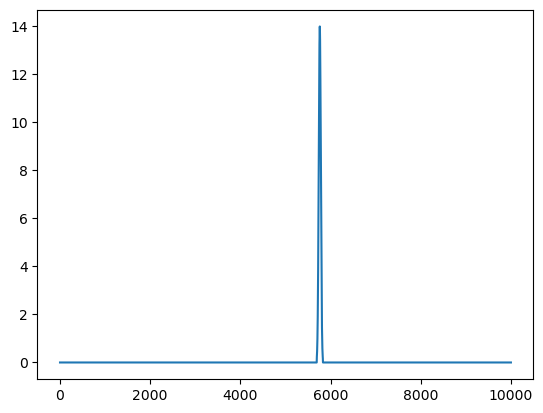

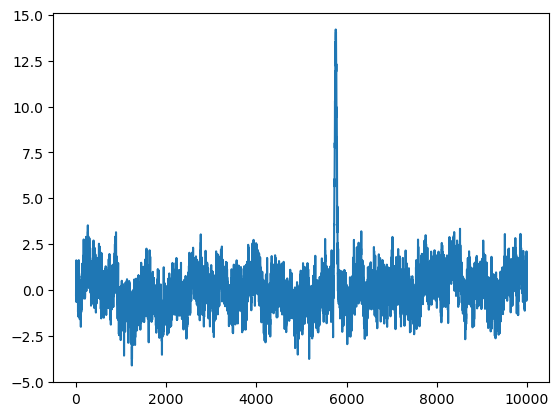

In [55]:
n = 10000
sr = 10000
std_min = 10
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3
c_freq = 100
m_index = 1
use_model = "deepclean"

# Build the signal
x, t = build_empty_signal(n, sr)
x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
plt.plot(x)
plt.show()
x_noised, noise = add_noise_to_signal(x, "pink", sr=sr)
plt.plot(x_noised)
plt.show()

In [57]:
dataset_size = 10_00
X = []  # unipolar gaussian + white noise
Y = []  # white noise
for _ in range(dataset_size):
    x, t = build_empty_signal(n, sr)
    x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
    x_noised, noise = add_noise_to_signal(x, "pink", sr=sr)
    X.append(x_noised)
    Y.append(noise)

In [58]:
X = torch.tensor(X).unsqueeze(dim=1).to(torch.float32)
Y = torch.tensor(Y).to(torch.float32)
print(X.shape)
print(Y.shape)

torch.Size([1000, 1, 10000])
torch.Size([1000, 10000])


# Training

In [59]:
# dataset generation
batch_size = 16
train_dataset = TensorDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model Instantiation
in_channels = 1
model = FFTDeepCleanAE(in_channels)
# model.load_state_dict(torch.load("deepclean_model.pth"))

data_for_viz = {}

In [60]:
# Loss function and optimizer
criterion = nn.MSELoss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    batch = 0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        if batch == 0:
            data_for_viz[epoch] = {} # data_for_viz.get(epoch, {})
            data_for_viz[epoch]["input"] = inputs.detach().numpy()
            data_for_viz[epoch]["input_encoding"] = model.encodings["input_conv"]
            for name, _, in list(model.downsampler.named_modules())[1:]:
                if "." in name: continue
                data_for_viz[epoch][f"downsample_{name}"] = model.encodings[f"downsample_{name}"]
            for name, _, in list(model.upsampler.named_modules())[1:]:
                if "." in name: continue
                data_for_viz[epoch][f"upsample_{name}"] = model.encodings[f"upsample_{name}"]
                
        batch += 1   
        
        # x1 = outputs
        # x2 = inputs - outputs
        # x3 = inputs
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
    
    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.10f}')

Epoch [1/100], Loss: 3.5338496859
Epoch [2/100], Loss: 1.8052019770
Epoch [3/100], Loss: 1.0524290431
Epoch [4/100], Loss: 0.7011907697
Epoch [5/100], Loss: 0.4885167371
Epoch [6/100], Loss: 0.3800904268
Epoch [7/100], Loss: 0.3184600283
Epoch [8/100], Loss: 0.2712385333
Epoch [9/100], Loss: 0.2395455459
Epoch [10/100], Loss: 0.2187076209
Epoch [11/100], Loss: 0.1961478182
Epoch [12/100], Loss: 0.1791642445
Epoch [13/100], Loss: 0.1686658126
Epoch [14/100], Loss: 0.1561564358
Epoch [15/100], Loss: 0.1483518342
Epoch [16/100], Loss: 0.1401755580
Epoch [17/100], Loss: 0.1344284099
Epoch [18/100], Loss: 0.1288587796
Epoch [19/100], Loss: 0.1221873906
Epoch [20/100], Loss: 0.1202383691
Epoch [21/100], Loss: 0.1213200904
Epoch [22/100], Loss: 0.1120543764
Epoch [23/100], Loss: 0.1055717783
Epoch [24/100], Loss: 0.1039838221
Epoch [25/100], Loss: 0.1026911916
Epoch [26/100], Loss: 0.1013244195
Epoch [27/100], Loss: 0.0995769120
Epoch [28/100], Loss: 0.0958655330
Epoch [29/100], Loss: 0.09371

In [61]:
torch.save(model, 'deepclean_test.pth')
import pickle

# Save the dictionary to a pickle file
with open('deepclean_encodings.pkl', 'wb') as f:
    pickle.dump(data_for_viz, f)

In [40]:
data_for_viz[0].keys()

dict_keys(['input', 'input_encoding', 'downsample_CONV_1', 'downsample_CONV_2', 'downsample_CONV_3', 'downsample_CONV_4', 'upsample_CONVTRANS_1', 'upsample_CONVTRANS_2', 'upsample_CONVTRANS_3', 'upsample_CONVTRANS_4'])

# Analysis

In [11]:
in_channels = 1
model = DeepCleanAE(in_channels)
model.load_state_dict(torch.load("deepclean_model.pth"))
model = model.eval()

In [35]:
batch_size = 16
train_dataset = TensorDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
criterion = nn.MSELoss()  # Suitable for classification tasks

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        
        x1 = outputs
        x2 = inputs.squeeze(dim=1) - outputs
        x3 = inputs.squeeze(dim=1)
        
        # Compute loss
        loss = criterion(outputs, labels)

        print("loss: ", loss.detach().item())
        
        break
        

loss:  0.21906450390815735


In [40]:
model.encodings["input_conv"]

(16, 1, 10000)

In [2]:
from models.fft_conv import _FFTConv

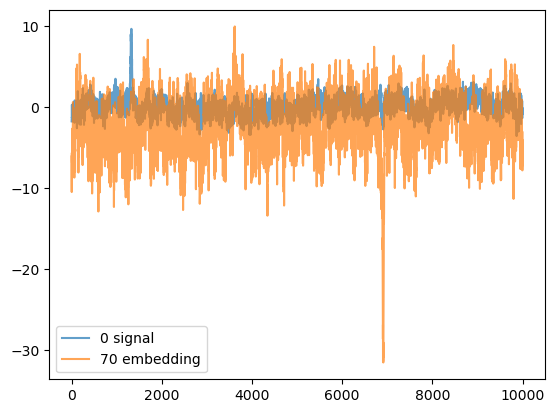

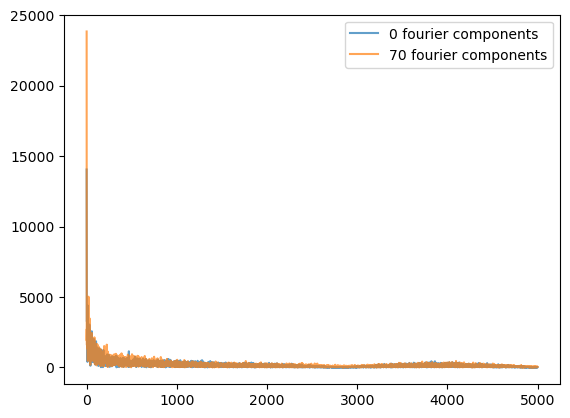

In [70]:
epoch = 0
epoch2 = 70
iev = 6
plt.plot(data_for_viz[epoch]["input"][iev].squeeze(), label=f"{epoch} signal", alpha=0.7)
# plt.plot(data_for_viz[epoch]["input_encoding"][iev].squeeze(), label=f"{epoch} embedding")
plt.plot(data_for_viz[epoch2]["input_encoding"][iev].squeeze(), label=f"{epoch2} embedding", alpha=0.7)
plt.legend()
plt.show()

sampling_rate = data_for_viz[epoch]["input_encoding"][iev].squeeze().shape[0]
y = torch.tensor(data_for_viz[epoch]["input_encoding"][iev].squeeze())
y_fft = torch.fft.fft(y)
frequencies = torch.fft.fftfreq(sampling_rate, d=1/sampling_rate)
plt.plot(frequencies[:len(frequencies)//2].numpy(), torch.abs(y_fft[:len(y_fft)//2]).numpy(), label = f"{epoch} fourier components", alpha=0.7)

sampling_rate = data_for_viz[epoch2]["input_encoding"][iev].squeeze().shape[0]
y = torch.tensor(data_for_viz[epoch2]["input_encoding"][iev].squeeze())
y_fft = torch.fft.fft(y)
frequencies = torch.fft.fftfreq(sampling_rate, d=1/sampling_rate)

plt.plot(frequencies[:len(frequencies)//2].numpy(), torch.abs(y_fft[:len(y_fft)//2]).numpy(), label=f"{epoch2} fourier components", alpha=0.7)
plt.legend()
plt.show()

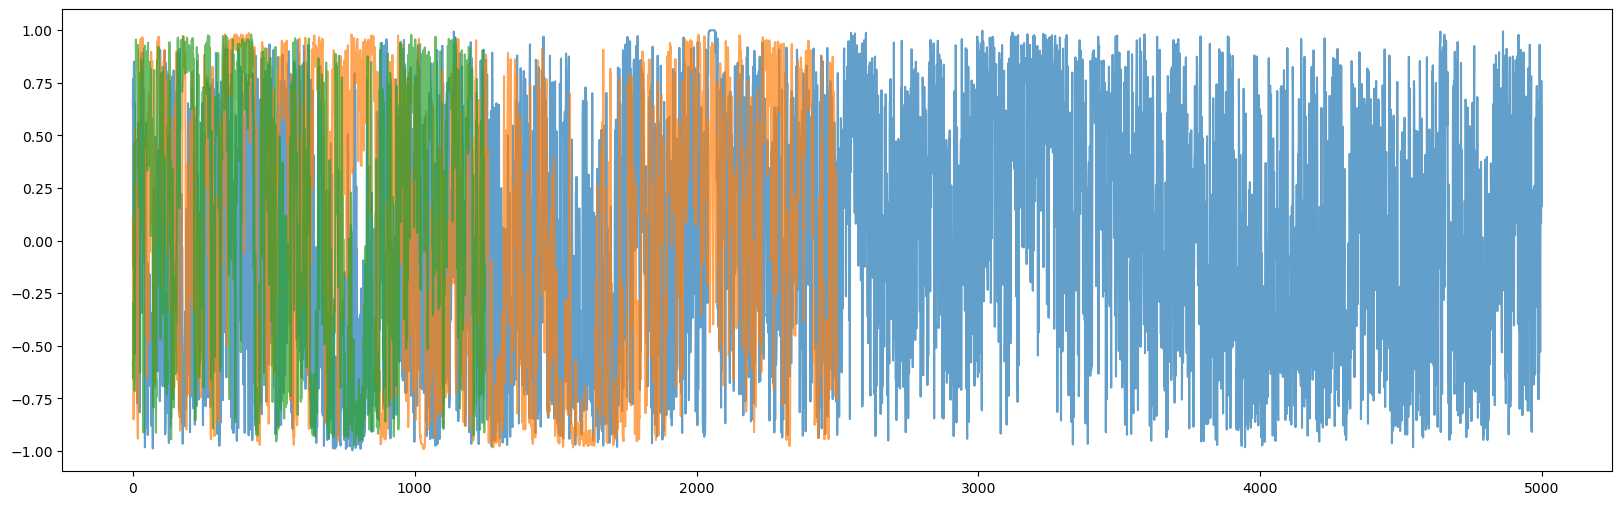

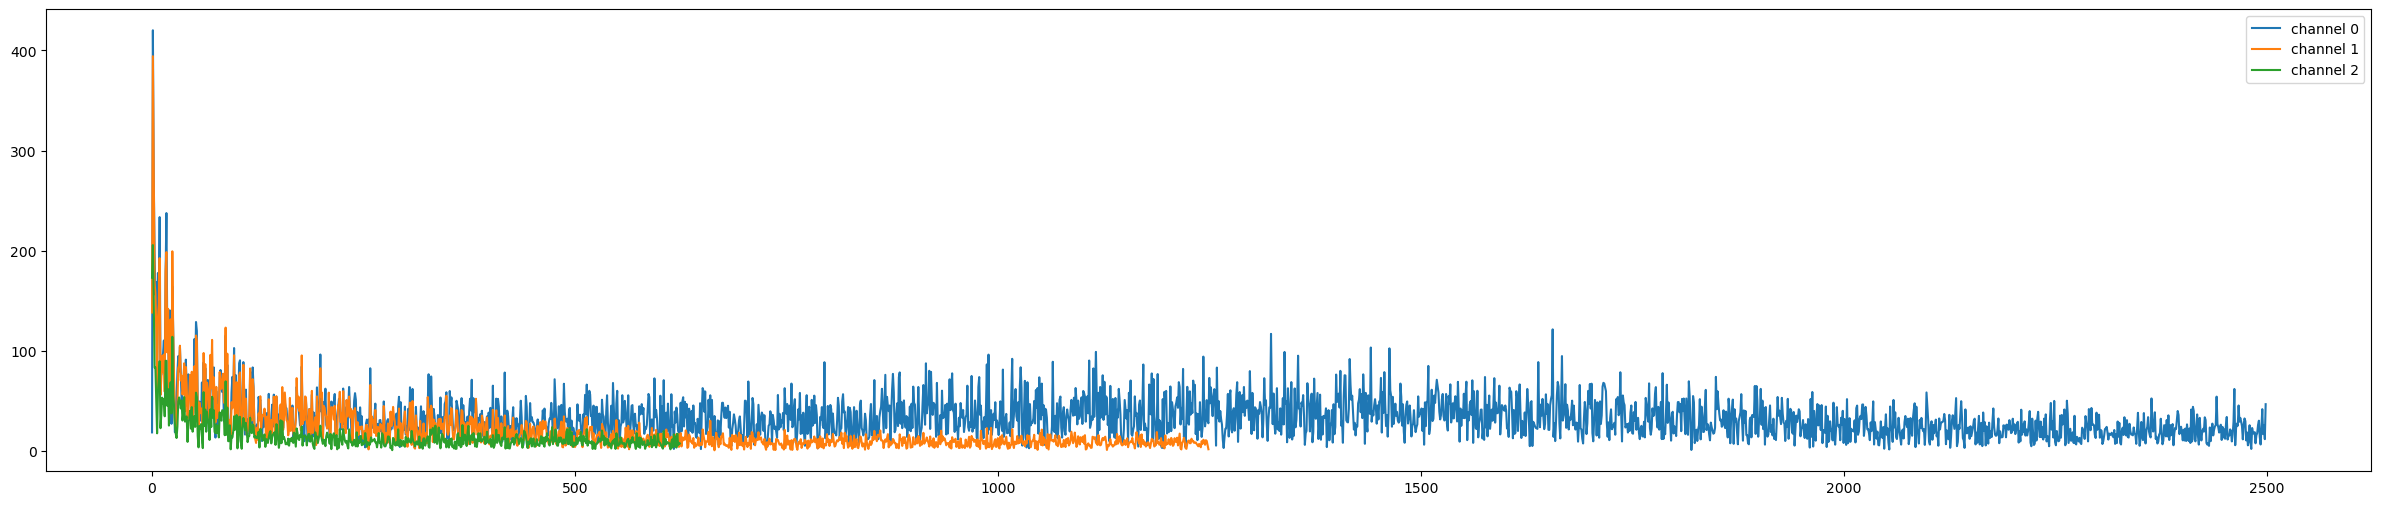

In [67]:
# plt.plot(data_for_viz[0]["downsample"][0][0])
# plt.plot(data_for_viz[0]["downsample"][0][1])
# plt.plot(data_for_viz[0]["downsample"][0][2])
epoch = 4
downsample_layer1 = "CONV_1"
downsample_layer2 = "CONV_2"
downsample_layer3 = "CONV_3"
batch = 0
iev = 0
channel = 0
channel2 = 1
channel3 = 2
plt.figure(figsize=(20, 6))
plt.plot(data_for_viz[epoch][f"downsample_{downsample_layer1}"][iev][channel], alpha=0.7)
plt.plot(data_for_viz[epoch][f"downsample_{downsample_layer2}"][iev][channel], alpha=0.7)
plt.plot(data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel], alpha=0.7)
plt.show()

plt.figure(figsize=(30, 6))
sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer1}"][iev][channel].shape[0]
y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer1}"][iev][channel])
y_fft = torch.fft.fft(y)
frequencies = torch.fft.fftfreq(sampling_rate, d=1/sampling_rate)
plt.plot(frequencies[:len(frequencies)//2].numpy(), torch.abs(y_fft[:len(y_fft)//2]).numpy(), label=f"channel {channel}")

sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer2}"][iev][channel].shape[0]
y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer2}"][iev][channel])
y_fft = torch.fft.fft(y)
frequencies = torch.fft.fftfreq(sampling_rate, d=1/sampling_rate)
plt.plot(frequencies[:len(frequencies)//2].numpy(), torch.abs(y_fft[:len(y_fft)//2]).numpy(), label=f"channel {channel2}")

sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel].shape[0]
y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel])
y_fft = torch.fft.fft(y)
frequencies = torch.fft.fftfreq(sampling_rate, d=1/sampling_rate)
plt.plot(frequencies[:len(frequencies)//2].numpy(), torch.abs(y_fft[:len(y_fft)//2]).numpy(), label=f"channel {channel3}")
plt.legend()
plt.show()


In [51]:
data_for_viz[0].keys()

dict_keys([0])